# Cel Projektu:
Stworzenie modelu, który dla dowolnego filmu dostępnego w ramce danych, przyporządkuje nam kilka rekomendcji na obejrzenie następnego filmu

## Biblioteki

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

## Podział danych

In [18]:
data = pd.read_csv('../Data/movie_statistic_dataset.csv')

In [19]:
our_data, validator_data = train_test_split(data, test_size = 0.2, random_state = 42)
our_data.to_csv('../Data/our_data.csv', index = False)
validator_data.to_csv('../Data/validator_data.csv', index = False)


X = our_data

X_train, X_val = train_test_split(
    X, test_size=0.2, random_state=42 #stratify mażnaby dodać ale wiem po jakiej kolumnie
)
X_val, X_test = train_test_split(
    X_val, test_size=0.3, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)

print("Nasze dane: " , our_data.shape, " dane walidatorów: ", validator_data.shape)

(2803, 14) (490, 14) (211, 14)
Nasze dane:  (3504, 14)  dane walidatorów:  (876, 14)


## EDA

In [20]:
df = pd.read_csv('../Data/our_data.csv')

### Wstępna analiza

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           3504 non-null   object 
 1   production_date       3504 non-null   object 
 2   genres                3504 non-null   object 
 3   runtime_minutes       3504 non-null   float64
 4   director_name         3504 non-null   object 
 5   director_professions  3504 non-null   object 
 6   director_birthYear    3504 non-null   object 
 7   director_deathYear    3504 non-null   object 
 8   movie_averageRating   3504 non-null   float64
 9   movie_numerOfVotes    3504 non-null   float64
 10  approval_Index        3504 non-null   float64
 11  Production budget $   3504 non-null   int64  
 12  Domestic gross $      3504 non-null   int64  
 13  Worldwide gross $     3504 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 383.4+ KB


### Opisy kolumn:
- Movie_title
- Production_date
- Genres
- Runtime_minutes
- Director_name (primaryName)
- Director_professions (primaryProfession)
- Director_birthYear
- Director_deathYear
- Movie_averageRating : refers to the average rating given by online users for particular movie
- Movie_numberOfVotes : refers to the number of votes given by online users for a particular movie
- Approval_Index :is a normalized indicator (on scale 0-10) calculated by multiplying the logarithm of the number of votes by the average users rating. It provides a concise measure of a movie's overall popularity and approval among online viewers, penalizing both films that got too few reviews and blockbusters that got too many.
- Production_budget ( $)
- Domestic_gross ($)
- Worldwide_gross ($)

In [22]:
df.isna().sum()

movie_title             0
production_date         0
genres                  0
runtime_minutes         0
director_name           0
director_professions    0
director_birthYear      0
director_deathYear      0
movie_averageRating     0
movie_numerOfVotes      0
approval_Index          0
Production budget $     0
Domestic gross $        0
Worldwide gross $       0
dtype: int64

In [23]:
df.duplicated().sum()

0

na 1 rzut oka nie mamy nulli i duplikatów

In [24]:
df.describe()

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
count,3504.000000,3504.000000,3.504000e+03,3504.000000,3.504000e+03,3.504000e+03,3.504000e+03
mean,109.824201,6.399287,1.347127e+05,5.015783,3.822253e+07,5.136379e+07,1.117665e+08
std,20.609065,1.025964,2.186926e+05,1.384769,4.556958e+07,7.395503e+07,1.976390e+08
min,63.000000,1.500000,5.000000e+00,0.395487,5.000000e+04,2.640000e+02,4.230000e+02
25%,95.000000,5.800000,2.094525e+04,4.184258,1.000000e+07,8.533081e+06,1.289494e+07
50%,106.000000,6.500000,6.355600e+04,5.022137,2.300000e+07,2.774971e+07,4.315913e+07
75%,120.000000,7.100000,1.556510e+05,5.918673,5.000000e+07,6.261151e+07,1.252223e+08
max,260.000000,9.300000,2.695887e+06,10.000000,4.600000e+08,8.583730e+08,2.923706e+09


### Rozkłady zmiennych numerycznych

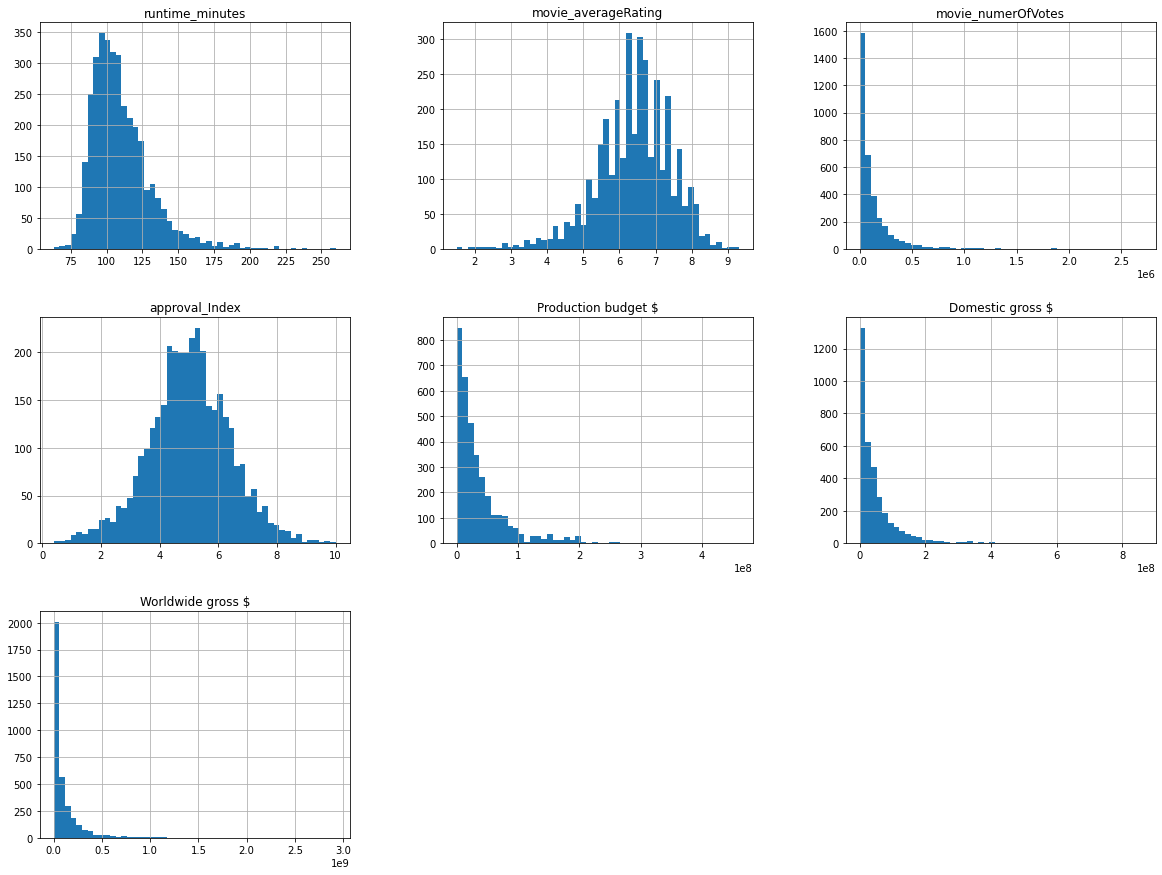

korelacje z Worldwide gross $


Worldwide gross $      1.000000
Domestic gross $       0.943244
Production budget $    0.732187
movie_numerOfVotes     0.572210
approval_Index         0.408324
runtime_minutes        0.234767
movie_averageRating    0.219798
Name: Worldwide gross $, dtype: float64

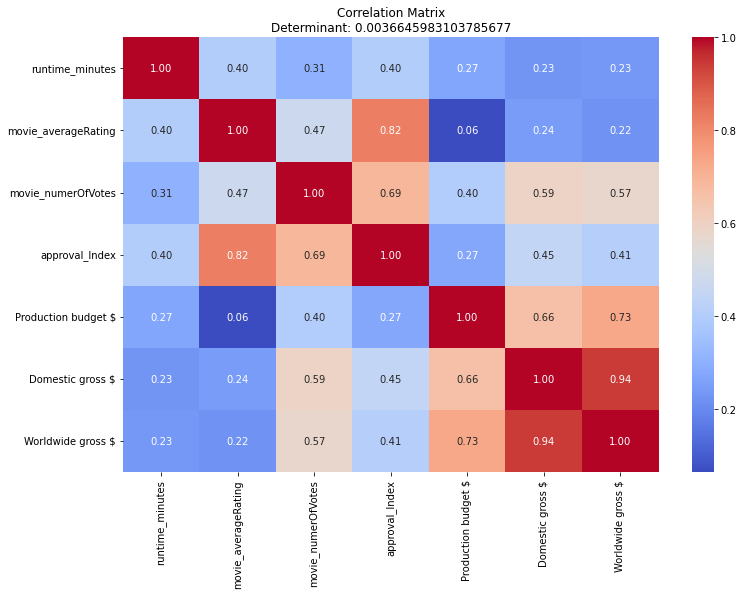

In [25]:
numerical_cols = df.select_dtypes(include=[np.number]).columns

#DLA DANYCH NUMERYCZNYCH ZBADAĆ ICH ROZKŁAD
df[numerical_cols].hist(bins=50, figsize=(20,15))
plt.show()

#ZNALEZIENIE KORELACJI MIĘDZY KOLUMNAMI
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
determinant = np.linalg.det(df.corr())
plt.title(f"Correlation Matrix\nDeterminant: {determinant}")

#SORTOWANIE KORELACJI DLA DANEJ KOLUMNY
corr_matrix = df.corr()
print("korelacje z Worldwide gross $")
corr_matrix["Worldwide gross $"].sort_values(ascending=False)

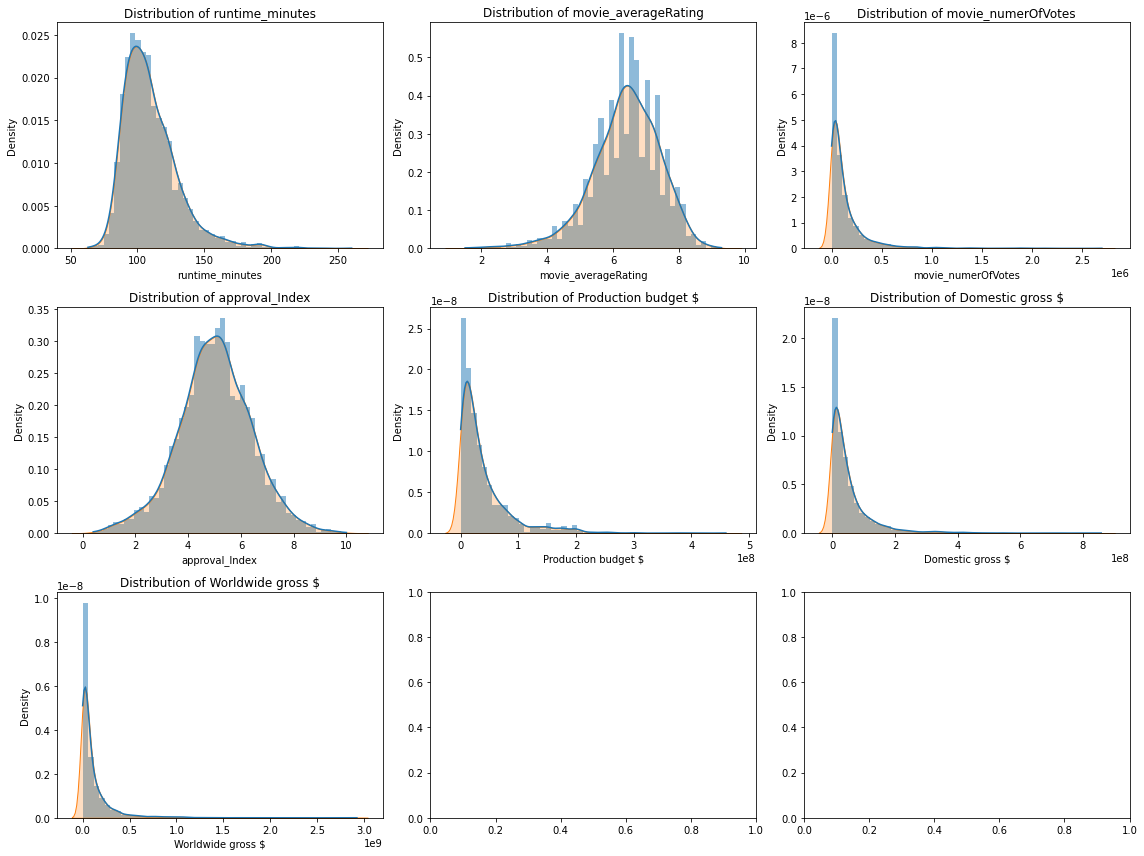

In [26]:

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axs[i], kde=True, stat="density", linewidth=0, bins=50)
    sns.kdeplot(df[col], ax=axs[i], fill=True)

    axs[i].set_title(f"Distribution of {col}")

fig.tight_layout()
plt.show()

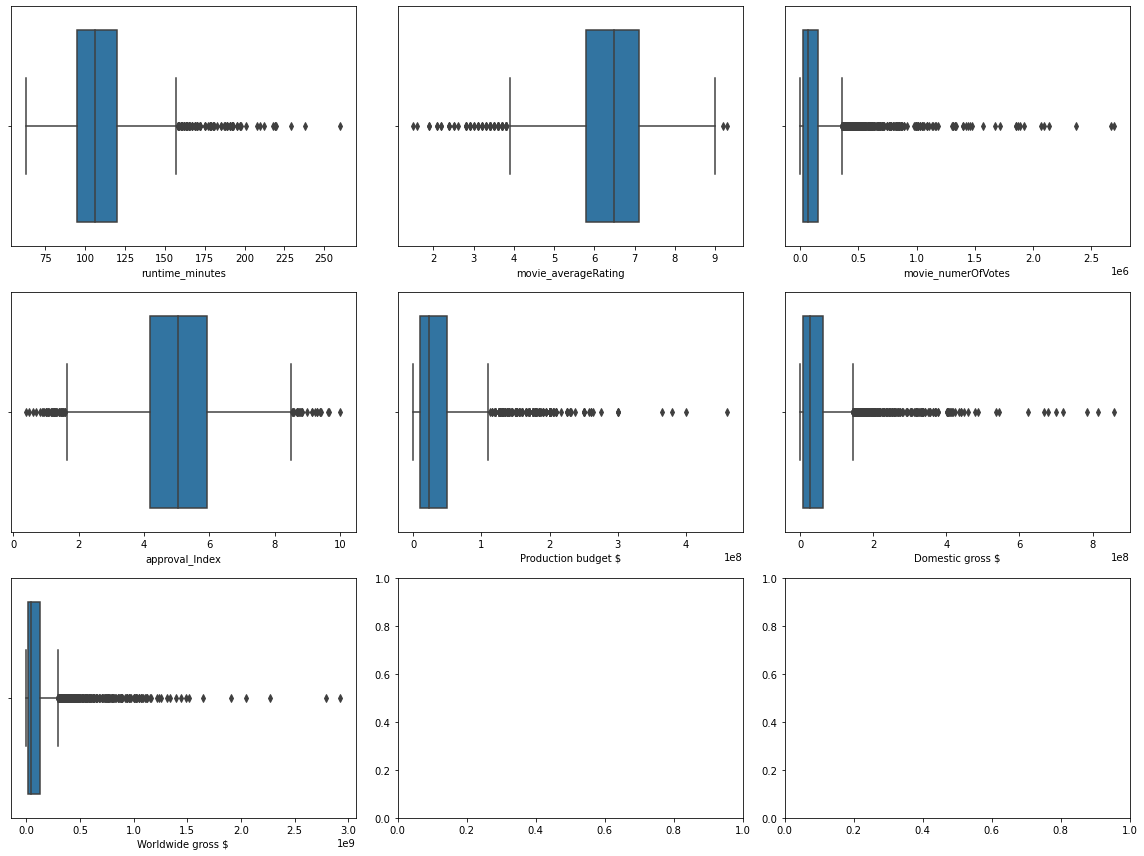

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axes = axs.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=col, data=df, ax=axes[i])

plt.tight_layout() 
plt.show()

### przeskalowanie logarytmiczne

array([[<AxesSubplot:title={'center':'runtime_minutes'}>,
        <AxesSubplot:title={'center':'movie_averageRating'}>,
        <AxesSubplot:title={'center':'movie_numerOfVotes'}>],
       [<AxesSubplot:title={'center':'approval_Index'}>,
        <AxesSubplot:title={'center':'Production budget $'}>,
        <AxesSubplot:title={'center':'Domestic gross $'}>],
       [<AxesSubplot:title={'center':'Worldwide gross $'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

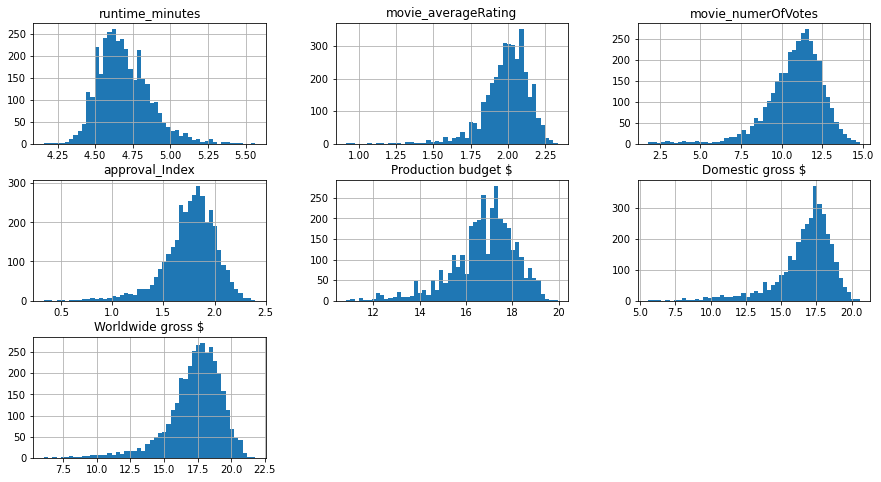

In [30]:
np.log1p(df[numerical_cols]).hist(bins=50, figsize=(15,8))

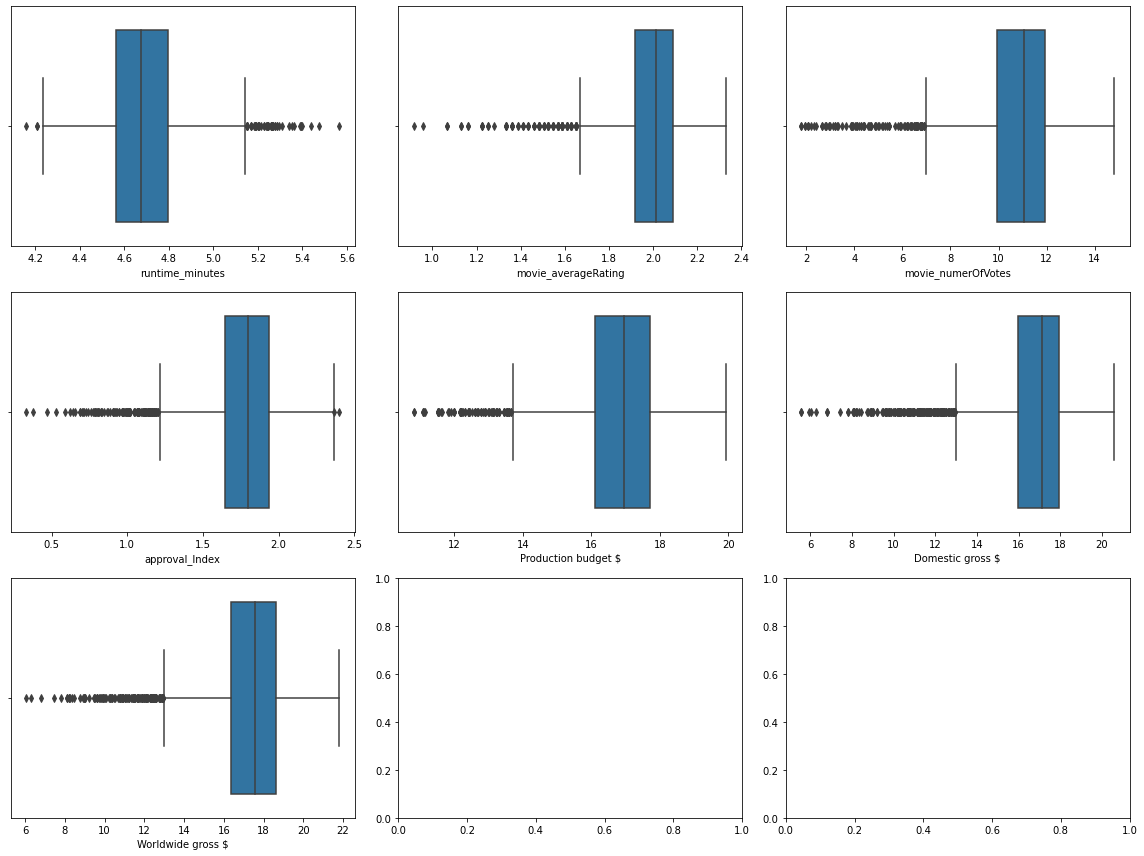

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axes = axs.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=col, data=np.log1p(df[numerical_cols]), ax= axes[i])
plt.tight_layout() 
plt.show()

obserwacje rozkładowe:
- approval index - zbliżony do normalnego
- budżety mają outliery z góry wartości
- number of votes ma outliery z góry


### Production Year

In [35]:
df["production_year"] = df["production_date"].str.split("-").str[0].astype(int)


#df = df.drop('production_date', axis=1)
df.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
0,Kansas City,1996-08-16,"Crime,Drama,Music",116.0,Robert Altman,"director,producer,writer",1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996
1,Sommersby,1993-02-05,"Drama,Mystery,Romance",114.0,Jon Amiel,"director,producer,script_department",1948,alive,6.2,22262.0,4.434679,30000000,50081992,140081992,1993
2,We Bought a Zoo,2011-12-23,"Comedy,Drama,Family",124.0,Cameron Crowe,"writer,producer,director",1957,alive,7.1,145614.0,6.078636,50000000,75624550,118729073,2011
3,The Spy Who Loved Me,1977-07-13,"Action,Adventure,Thriller",125.0,Lewis Gilbert,"director,writer,producer",1920,2018,7.0,110757.0,5.850243,14000000,46800000,185400000,1977
4,Next Friday,2000-01-12,Comedy,98.0,Steve Carr,"director,producer",\N,alive,6.1,41748.0,4.643223,9500000,57176582,59675307,2000


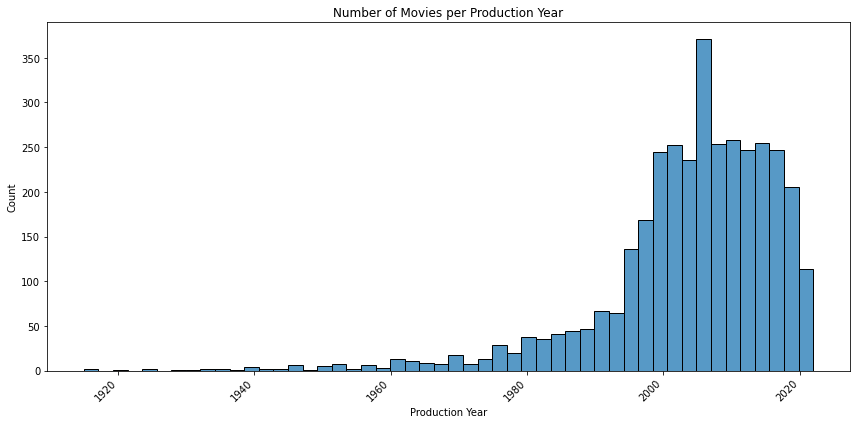

In [57]:
plt.figure(figsize=(12, 6))
histplot = sns.histplot(data=df, x='production_year', bins=50)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Production Year')
plt.title('Number of Movies per Production Year')
plt.tight_layout()
plt.show()

### Analiza Genres

In [37]:
df_expanded = df.drop('genres', axis=1).join(df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genres'))
df_expanded.head()

,movie_title,production_date,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year,genres
0,Kansas City,1996-08-16,116.0,Robert Altman,"director,producer,writer",1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,Crime
0,Kansas City,1996-08-16,116.0,Robert Altman,"director,producer,writer",1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,Drama
0,Kansas City,1996-08-16,116.0,Robert Altman,"director,producer,writer",1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,Music
1,Sommersby,1993-02-05,114.0,Jon Amiel,"director,producer,script_department",1948,alive,6.2,22262.0,4.434679,30000000,50081992,140081992,1993,Drama
1,Sommersby,1993-02-05,114.0,Jon Amiel,"director,producer,script_department",1948,alive,6.2,22262.0,4.434679,30000000,50081992,140081992,1993,Mystery


In [38]:
genres_per_film = df["movie_title"].value_counts()
for wystapienie in range(1,10):
    print(f"wystepujace {wystapienie}: ", (genres_per_film == wystapienie).sum())

wystepujace 1:  3328
wystepujace 2:  79
wystepujace 3:  6
wystepujace 4:  0
wystepujace 5:  0
wystepujace 6:  0
wystepujace 7:  0
wystepujace 8:  0
wystepujace 9:  0


Drama          1784
Comedy         1347
Action          946
Adventure       743
Crime           629
Romance         596
Thriller        530
Horror          366
Mystery         323
Sci-Fi          296
Biography       274
Fantasy         266
Family          216
Animation       191
Music           121
History         121
Sport            90
War              65
Documentary      49
Musical          41
Western          34
Film-Noir         6
News              1
Name: genres, dtype: int64


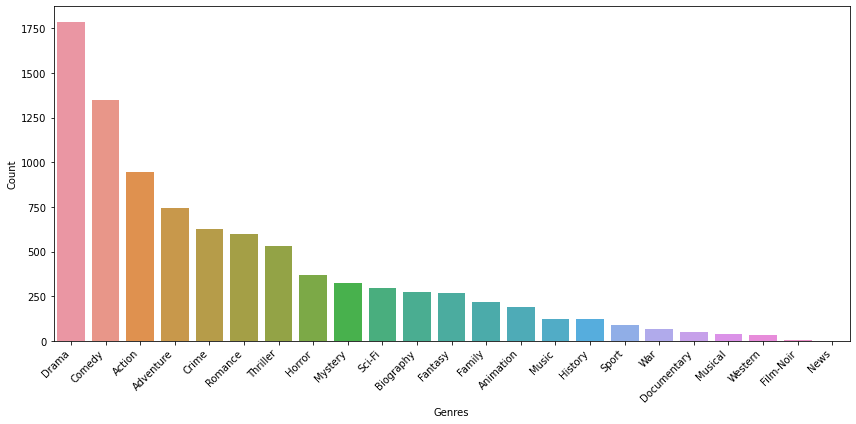

In [60]:
print(df_expanded['genres'].value_counts())

plt.figure(figsize=(12, 6))
countplot = sns.countplot(data=df_expanded, x='genres', order=df_expanded['genres'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [40]:
genre_financial_data = df_expanded.groupby('genres').agg({
    'Domestic gross $': 'mean',
    'Worldwide gross $': 'mean'
}).reset_index()

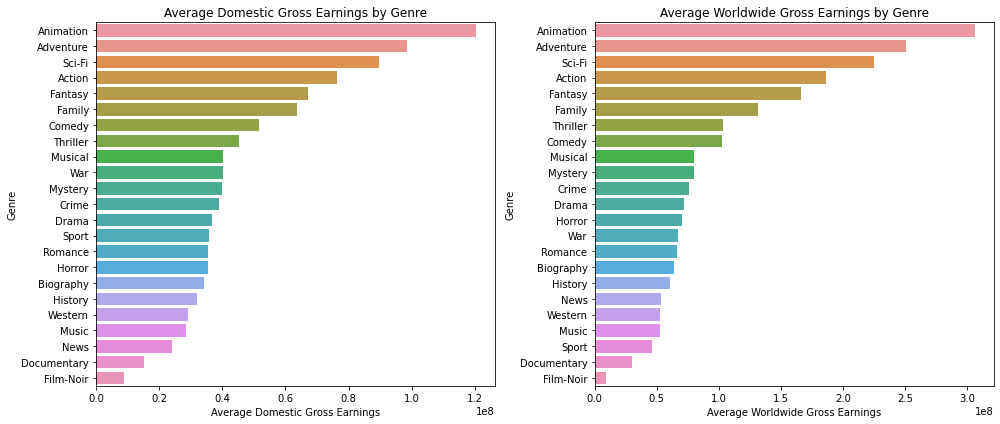

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Domestic gross $', y='genres', ax=axs[0] ,data=genre_financial_data.sort_values('Domestic gross $', ascending=False))
axs[0].set_title('Average Domestic Gross Earnings by Genre')
axs[0].set_xlabel('Average Domestic Gross Earnings')
axs[0].set_ylabel('Genre')

sns.barplot(x='Worldwide gross $', y='genres', ax=axs[1],data=genre_financial_data.sort_values('Worldwide gross $', ascending=False))
axs[1].set_title('Average Worldwide Gross Earnings by Genre')
axs[1].set_xlabel('Average Worldwide Gross Earnings')
axs[1].set_ylabel('Genre')

plt.tight_layout()
plt.show()

### Szczególowa analiza duplikatów

In [42]:
counts = df.groupby(['movie_title', 'production_date']).size()
print(counts[counts > 1].sort_values(ascending=False))

movie_title          production_date
Weekend              2011-09-23         3
The Visit            2015-09-10         3
Brothers             2015-08-13         3
Redemption           2013-06-28         3
The Family           2013-09-13         2
Spiral               2021-05-12         2
Spotlight            2015-11-06         2
Stronger             2017-09-22         2
The Artist           2011-10-12         2
The Calling          2002-03-01         2
The Circle           2017-04-28         2
The Great Wall       2016-12-15         2
The Forest           2016-01-07         2
The Night Before     2015-11-12         2
The Promise          2017-04-21         2
The Tempest          2010-12-10         2
Truth or Dare        2018-04-12         2
Underdogs            2013-08-16         2
Upside Down          2012-08-23         2
Smile                2022-09-28         2
Alice in Wonderland  2010-03-04         2
An Ideal Husband     1999-06-18         2
Cyrus                2010-06-18        

In [43]:
##przkłady takich filmów:
df[df['movie_title'] == 'Weekend'].head()


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
564,Weekend,2011-09-23,"Drama,Romance",97.0,Andrew Haigh,"producer,director,writer",1973,alive,7.6,30966.0,5.650357,190000,484592,1577585,2011
1009,Weekend,2011-09-23,"Comedy,Drama",80.0,Randal Kamradt,"visual_effects,producer,director",\N,alive,5.8,7.0,0.698560,190000,484592,1577585,2011
2072,Weekend,2011-09-23,"Action,Comedy,Crime",121.0,Cezary Pazura,"actor,producer,director",1962,alive,3.9,705.0,1.749999,190000,484592,1577585,2011


In [44]:
df[df['movie_title'] == 'Brothers'].head() 


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
2930,Brothers,2015-08-13,"Action,Drama,Sport",156.0,Karan Malhotra,"assistant_director,director,writer",\N,alive,6.4,13327.0,4.340382,13000000,656688,17856688,2015
3106,Brothers,2015-08-13,Documentary,100.0,Aslaug Holm,"director,cinematographer,editor",\N,alive,7.6,371.0,3.176338,13000000,656688,17856688,2015
3295,Brothers,2015-08-13,Documentary,68.0,Wojciech Staron,"cinematographer,camera_department,miscellaneous",1973,alive,7.4,81.0,2.260754,13000000,656688,17856688,2015


In [45]:
df[df['movie_title'] == 'The Circle'].head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
3093,The Circle,2017-04-28,"Drama,Sci-Fi,Thriller",110.0,James Ponsoldt,"director,producer,writer",1978,alive,5.3,94340.0,4.334893,18000000,20497844,40651864,2017
3428,The Circle,2017-04-28,"Drama,Horror,Thriller",93.0,Peter Callow,"director,editor,producer",\N,alive,4.8,495.0,2.059376,18000000,20497844,40651864,2017


### Filmy które mają po kilka części

In [46]:
df[df['movie_title'].str.contains('Alvin')].head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
27,Alvin and the Chipmunks: The Squeakquel,2009-12-23,"Adventure,Animation,Comedy",88.0,Betty Thomas,"actress,director,producer",1947,alive,4.5,50525.0,3.453928,70000000,219614612,443483213,2009
505,Alvin and the Chipmunks: Chipwrecked,2011-12-14,"Adventure,Animation,Comedy",87.0,Mike Mitchell,"miscellaneous,writer,director",1970,alive,4.3,36528.0,3.191933,80000000,133107389,349088523,2011
961,Alvin and the Chipmunks,2007-12-14,"Adventure,Animation,Comedy",92.0,Tim Hill,"writer,producer,director",1958,alive,5.2,88062.0,4.224269,55000000,217326974,362605033,2007
2876,Alvin and the Chipmunks: The Road Chip,2015-12-18,"Adventure,Animation,Comedy",92.0,Walt Becker,"director,producer,writer",1968,alive,4.9,20484.0,3.447177,90000000,85886987,249517956,2015


In [47]:
df[df['movie_title'].str.contains('Twilight')].head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year
12,The Twilight Saga: Eclipse,2010-06-30,"Action,Adventure,Drama",124.0,David Slade,"producer,director,writer",1969,alive,5.0,249281.0,4.439516,68000000,300531751,706102828,2010
1697,Twilight Zone: The Movie,1983-06-24,"Horror,Sci-Fi",101.0,-,-,-,-,6.4,38741.0,4.842862,10000000,29500000,29500000,1983
3425,Twilight,2008-11-21,"Drama,Fantasy,Romance",122.0,Catherine Hardwicke,"director,production_designer,producer",1955,alive,5.3,466675.0,4.958314,37000000,192769854,402278564,2008


Mamy w danych filmy gdzie jest po kilka części, fajnie by było to jakoś zaznaczyć/zakodować. W Alvinie fajnie można zauważyć że w kolejnych filmach average rating spada, dopiero w ostatnim (2015) się podnosi, w kolejnej części Twilight też jest niższy rating.

### Analiza zmiennych kategorycznych

In [48]:
categorical_col = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_col:
    print(f"{col}: {df[col].nunique()} unique values")

movie_title: 3413 unique values
production_date: 2143 unique values
genres: 312 unique values
director_name: 1617 unique values
director_professions: 293 unique values
director_birthYear: 101 unique values
director_deathYear: 59 unique values


In [49]:
df.director_name.value_counts().head(20)

-                    265
Steven Spielberg      21
Clint Eastwood        19
Martin Scorsese       18
Ridley Scott          17
Woody Allen           17
Steven Soderbergh     14
Michael Bay           12
Oliver Stone          12
Spike Lee             12
Tim Burton            12
Brian De Palma        11
Renny Harlin          11
Ron Howard            11
Tony Scott            11
Robert Zemeckis       11
Richard Donner        10
Joel Schumacher       10
F. Gary Gray           9
Barry Levinson         9
Name: director_name, dtype: int64

In [50]:
#check how many "-" or "\N" values in each column
print('wartości brakujące w postaci "-":')
for col in df.columns:
    if df[col][df[col] == '-'].count() > 0:
        print(col, df[col][df[col] == '-'].count())

print('\nwartości brakujące w postaci "\\N":')
for col in df.columns:
     if df[col][df[col] == '\\N'].count() > 0:
        print(col, df[col][df[col] == '\\N'].count())

print('\nliczba żywych rezyserów:')
for col in df.columns:
     if df[col][df[col] == "alive"].count() > 0:
        print(col, df[col][df[col] == 'alive'].count())

wartości brakujące w postaci "-":
director_name 265
director_professions 270
director_birthYear 265
director_deathYear 265

wartości brakujące w postaci "\N":
director_birthYear 468

liczba żywych rezyserów:
director_deathYear 2899


In [51]:
for col in categorical_col:
    print(df[col].value_counts())

Brothers                 3
Halloween                3
Hercules                 3
The Visit                3
Weekend                  3
                        ..
The Brothers McMullen    1
The Lost City            1
Catch That Kid           1
The Devil Inside         1
A Civil Action           1
Name: movie_title, Length: 3413, dtype: int64
2000-12-22    8
2008-10-24    8
2005-09-23    7
2005-09-16    7
2015-11-12    6
             ..
2013-06-21    1
2000-12-27    1
2003-10-22    1
2018-10-12    1
1995-12-29    1
Name: production_date, Length: 2143, dtype: int64
Comedy,Drama,Romance          157
Adventure,Animation,Comedy    129
Drama                         127
Comedy                        125
Comedy,Drama                  123
                             ... 
Documentary,Drama,Family        1
Action,Fantasy,Thriller         1
Animation,Family,History        1
Drama,Family,Western            1
Action,Fantasy,Sci-Fi           1
Name: genres, Length: 312, dtype: int64
-                

wystepujace 1:  254
wystepujace 2:  43
wystepujace 3:  3031
wystepujace 4:  18
wystepujace 5:  2
wystepujace 6:  60
wystepujace 7:  0
wystepujace 8:  0
wystepujace 9:  5


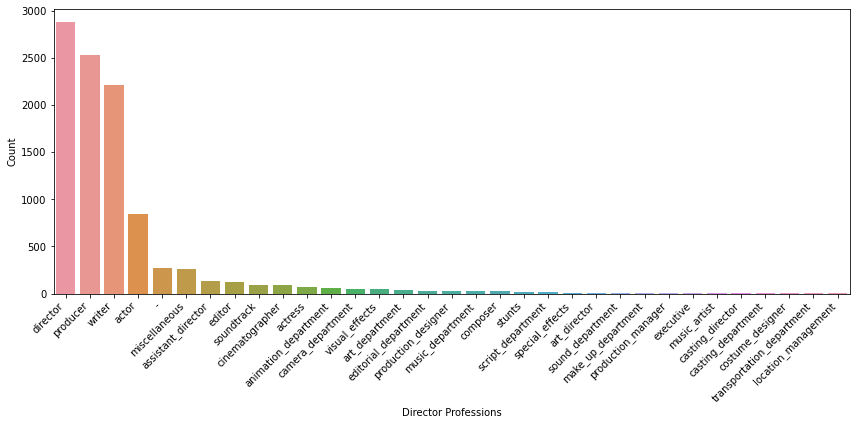

,movie_title,production_date,genres,runtime_minutes,director_name,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year,number_of_professions
0,Kansas City,1996-08-16,"Crime,Drama,Music",116.0,Robert Altman,1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,3
1,Sommersby,1993-02-05,"Drama,Mystery,Romance",114.0,Jon Amiel,1948,alive,6.2,22262.0,4.434679,30000000,50081992,140081992,1993,3
2,We Bought a Zoo,2011-12-23,"Comedy,Drama,Family",124.0,Cameron Crowe,1957,alive,7.1,145614.0,6.078636,50000000,75624550,118729073,2011,3
3,The Spy Who Loved Me,1977-07-13,"Action,Adventure,Thriller",125.0,Lewis Gilbert,1920,2018,7.0,110757.0,5.850243,14000000,46800000,185400000,1977,3
4,Next Friday,2000-01-12,Comedy,98.0,Steve Carr,\N,alive,6.1,41748.0,4.643223,9500000,57176582,59675307,2000,2


In [52]:
df_roboczy = df.drop('director_professions', axis=1).join(df['director_professions'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('director_professions'))
# sprawdzmy po ile mamy filmów z 1,2,3 gatunkami:
professions_per_film = df_roboczy["movie_title"].value_counts()
for wystapienie in range(1,10):
    print(f"wystepujace {wystapienie}: ", (professions_per_film == wystapienie).sum())

plt.figure(figsize=(12, 6))
countplot = sns.countplot(data=df_roboczy, x='director_professions', order = df_roboczy['director_professions'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Director Professions')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

df['number_of_professions'] = df['director_professions'].apply(lambda x: len(x.split(',')))
df.drop('director_professions', axis=1, inplace=True)
df.head()

In [53]:
director_data = df.groupby('director_name').agg({
    'movie_averageRating': 'mean',
    'Domestic gross $': 'mean',
    'Worldwide gross $': 'mean'
}).reset_index()
director_data.head()

,director_name,movie_averageRating,Domestic gross $,Worldwide gross $
0,-,6.481132,8.493153e+07,2.058860e+08
1,Aaron Woodley,4.800000,5.801249e+06,1.128515e+07
2,Abderrahmane Sissako,7.100000,1.076075e+06,6.815821e+06
3,Abel Ferrara,6.600000,1.212799e+06,1.412799e+06
4,Adam Marcus,4.100000,1.593507e+07,1.593507e+07


In [54]:
top_directors_rating = director_data.sort_values('movie_averageRating', ascending=False).head(15)
top_directors_rating

,director_name,movie_averageRating,Domestic gross $,Worldwide gross $
1431,Steve Kopera,9.000000,6.260000e+03,6.260000e+03
1494,Tim Martin Crouse,8.700000,3.668600e+04,1.359347e+07
193,Charles Chaplin,8.500000,1.632450e+05,2.295490e+05
1537,Tony Kaye,8.500000,6.719864e+06,6.719864e+06
1604,Yann Arthus-Bertrand,8.500000,1.543300e+04,4.479317e+07
278,Dana Kjeldsen,8.500000,1.535146e+07,6.185044e+07
724,John Lasseter,8.300000,1.925232e+08,3.652710e+08
895,Lee Unkrich,8.300000,4.150049e+08,1.068880e+09
1371,Sergio Leone,8.300000,5.321508e+06,5.576072e+06
1113,Nitesh Tiwari,8.300000,1.239176e+07,3.051495e+08


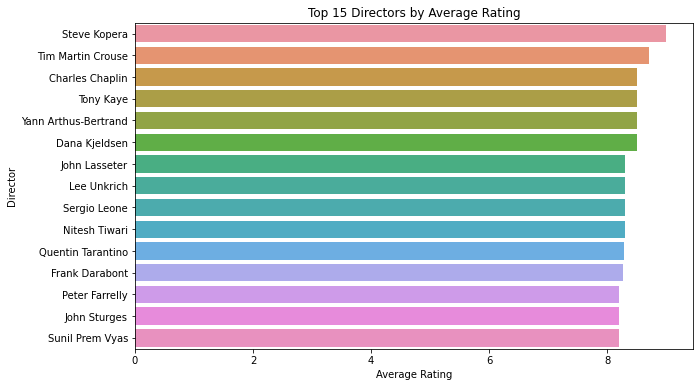

In [55]:
plt.figure(figsize=(10,6))
sns.barplot(x='movie_averageRating', y='director_name', data=top_directors_rating)
plt.title('Top 15 Directors by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Director')
plt.show()

## Propozycja encodingu genres

In [56]:
# One-hot encode the genres

genres_one_hot = df['genres'].str.get_dummies(sep=',')

# Concatenate the original DataFrame with the new one-hot encoded genres
df = pd.concat([df, genres_one_hot], axis=1)

# Drop the original 'genres' column if it's no longer needed
df.drop('genres', axis=1, inplace=True)

df.head()

,movie_title,production_date,runtime_minutes,director_name,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,Kansas City,1996-08-16,116.0,Robert Altman,1925,2006,6.3,5077.0,3.823171,19000000,...,1,0,0,0,0,0,0,0,0,0
1,Sommersby,1993-02-05,114.0,Jon Amiel,1948,alive,6.2,22262.0,4.434679,30000000,...,0,0,1,0,1,0,0,0,0,0
2,We Bought a Zoo,2011-12-23,124.0,Cameron Crowe,1957,alive,7.1,145614.0,6.078636,50000000,...,0,0,0,0,0,0,0,0,0,0
3,The Spy Who Loved Me,1977-07-13,125.0,Lewis Gilbert,1920,2018,7.0,110757.0,5.850243,14000000,...,0,0,0,0,0,0,0,1,0,0
4,Next Friday,2000-01-12,98.0,Steve Carr,\N,alive,6.1,41748.0,4.643223,9500000,...,0,0,0,0,0,0,0,0,0,0
